# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 1: Introduction to Web Scraping

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Section Leaders**: Cecilia Garraffo, Mehul Smriti Raje, Ken Arnold, Karan Motwani<br/>

---

In [99]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

---

When we're done today, you will approach messy real-world data with confidence that you can get it into a format that you can manipulate.

Specifically, our learning objectives are:
* Understand the structure of an HTML document and use that structure to extract desired information
* Use Python data structures such as lists, dictionaries, and Pandas DataFrames to store and manipulate information
* Identify some other (semi-)structured formats commonly used for storing and transferring data, such as JSON and CSV
* Practice using [Python](https://docs.python.org/3.6/) packages such as [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [Pandas](https://pandas.pydata.org/pandas-docs/stable/), including how to navigate their documentation to find functionality.

In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
import json

import requests
from bs4 import BeautifulSoup
from IPython.display import HTML

In [56]:
# Setting up 'requests' to make HTTPS requests properly takes some extra steps... we'll skip them for now.
requests.packages.urllib3.disable_warnings()

## Goals

Is science becoming more collaborative over time? How about literature? Are there a few "geniuses" or lots of hard workers? One way we might answer those questions is by looking at Nobel Prizes. We could ask questions like:

* How has the number of recipients per award changed over time?
* Has anyone won a prize more than once?

To answer these questions, we'll need data: *who* received *what* award *when*. 

Before we dive into acquiring this data the way we've been teaching in class, let's pause to ask: **what are 5 different approaches we could take to acquiring Nobel Prize data**?





## Ingesting data

Turns out that https://www.nobelprize.org/prizes/lists/all-nobel-prizes/ has the data we want. But the `nobelprize.org` server is a little slow sometimes. Fortunately, the Internet Archive periodically crawls most of the Internet and saves what it finds. (That's a lot of data!) So let's grab the data from the Archive's "Wayback Machine" (great name!).

We'll just give you the direct URL, but at the very end you'll see how we can get it out of a JSON response from the Wayback Machine API.

In [57]:
snapshot_url = 'http://web.archive.org/web/20180820111639/https://www.nobelprize.org/prizes/lists/all-nobel-prizes/'

In [58]:
snapshot = requests.get(snapshot_url)

Always remember to “not to be evil” when scraping with requests! If downloading multiple pages (like you will be on HW1), always put a delay between requests (e.g, `time.sleep(1)`, with the `time` library) so you don’t unwittingly hammer someone’s webserver and/or get blocked.

In [59]:
raw_html = snapshot.text
print(raw_html[:500])

	<!DOCTYPE html>

	<html lang="en-US" prefix="og: http://ogp.me/ns#" class="no-js">

	<head><script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript"></script>
<script type="text/javascript">window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app42.us.archive.org';v.server_ms=562;archive_analytics.send_pageview({});});</script>
<script type="text/javascript" src="/static/js/ait-client-rewrite.js?v=154949


Now, we have all our data in the notebook. Unfortunately, it is the form of one really long string, which is hard to work with directly. This is where BeautifulSoup comes in.  

## Parse the HTML with BeautifulSoup

In [60]:
soup = BeautifulSoup(raw_html, 'html.parser')

Key BeautifulSoup functions we’ll be using in this section:
- **`node.prettify()`**: Returns cleaned-up version of raw HTML, useful for printing
- **`node.select(selector)`**: Return a list of nodes matching a [CSS selector](https://developer.mozilla.org/en-US/docs/Learn/CSS/Introduction_to_CSS/Simple_selectors)
- **`node.select_one(selector)`**: Return the first node matching a CSS selector
- **`node.text/soup.get_text()`**: Returns visible text of a node (e.g.,"`<p>Some text</p>`" -> "Some text")
- **`node.contents`**: A list of the immediate children of this node

You can also use these functions to find nodes.
- **`node.find_all(tag_name, attrs=attributes_dict)`**: Returns a list of matching nodes
- **`node.find(tag_name, attrs=attributes_dict)`**: Returns first matching node

BeautifulSoup is a very powerful library -- much more info here: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

### Let's practice some BeautifulSoup commands...

**Print a cleaned-up version of the raw HTML**

In [61]:
# Your code here
print(soup.prettify()[:500])

<!DOCTYPE html>
<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">
 <head>
  <script src="//archive.org/includes/analytics.js?v=cf34f82" type="text/javascript">
  </script>
  <script type="text/javascript">
   window.addEventListener('DOMContentLoaded',function(){var v=archive_analytics.values;v.service='wb';v.server_name='wwwb-app42.us.archive.org';v.server_ms=562;archive_analytics.send_pageview({});});
  </script>
  <script charset="utf-8" src="/static/js/ait-client-rewrite.js?v=


** Find the first “title” object ** 

In [62]:
soup.select_one('title')

<title>All Nobel Prizes</title>

** Extract the text of first “title” object ** 

In [63]:
soup.select_one('title').text

'All Nobel Prizes'

## Extracting award data

Let's use the structure of the HTML document to extract the data we want.

From inspecting the page in DevTools, we found that each award is in a `div` with a `by_year` class. Let's get all of them.

In [64]:
award_nodes = soup.select('.by_year')
len(award_nodes)

640

Let's pull out an example.

In [65]:
award_node = award_nodes[200]

In [66]:
HTML(award_node.prettify())

#### Let's practice getting data out of a BS Node

### The prize title

In [67]:
award_node.select_one('h3').text

'The Nobel Prize in Physiology or Medicine 1985'

**How do we separate the title from the year?**

In [68]:
award_node.select_one('h3').text[:-5]

'The Nobel Prize in Physiology or Medicine'

In [69]:
def get_award_title(award_node):
    return award_node.select_one('h3').text[:-4].strip()

In [70]:
def get_award_year(award_node):
    return int(award_node.select_one('h3').text[-4:])

**Make a list of titles for all awards**

In [71]:
[get_award_title(award_node) for award_node in award_nodes]

['The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'The Nobel Prize in Physics',
 'The Nobel Prize in Chemistry',
 'The Nobel Prize in Physiology or Medicine',
 'The Nobel Prize in Literature',
 'The Nobel Peace Prize',
 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
 'Th

**Make a list of dictionaries of the title and year for all awards.**

In [72]:
[
    dict(
        title=get_award_title(award_node),
        year=get_award_year(award_node))
    for award_node in award_nodes
]

[{'title': 'The Nobel Prize in Physics', 'year': 2018},
 {'title': 'The Nobel Prize in Chemistry', 'year': 2018},
 {'title': 'The Nobel Prize in Physiology or Medicine', 'year': 2018},
 {'title': 'The Nobel Prize in Literature', 'year': 2018},
 {'title': 'The Nobel Peace Prize', 'year': 2018},
 {'title': 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
  'year': 2018},
 {'title': 'The Nobel Prize in Physics', 'year': 2017},
 {'title': 'The Nobel Prize in Chemistry', 'year': 2017},
 {'title': 'The Nobel Prize in Physiology or Medicine', 'year': 2017},
 {'title': 'The Nobel Prize in Literature', 'year': 2017},
 {'title': 'The Nobel Peace Prize', 'year': 2017},
 {'title': 'The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel',
  'year': 2017},
 {'title': 'The Nobel Prize in Physics', 'year': 2016},
 {'title': 'The Nobel Prize in Chemistry', 'year': 2016},
 {'title': 'The Nobel Prize in Physiology or Medicine', 'year': 2016},
 {'title': 'T

### The recipients
**how do we handle there being more than one?**

In [73]:
[node.text for node in award_node.select('h6 a')]

['Michael S. Brown', 'Joseph L. Goldstein']

We'll leave them as a list for now, to return to this later.

### The prize "motivation"

In [74]:
award_node.select_one('p').text

'“for their discoveries concerning the regulation of cholesterol metabolism”'

In [75]:
def get_award_motivation(award_node):
    award_node = award_node.select_one('p')
    if not award_node:
        return None
    return award_node.text #.lstrip('\u201c').rstrip('\u201d')

In [76]:
def get_recipients(award_node):
    return [node.text for node in award_node.select('h6 a')]

Now let's get all of the awards.

In [77]:
awards = []
for award_node in soup.select('.by_year'):
    recipients = get_recipients(award_node)
    award = {}
    award['title'] = get_award_title(award_node)
    award['year'] = get_award_year(award_node)
    award['recipients'] = recipients
    award['num_recipients'] = len(recipients)
    award['motivation'] = get_award_motivation(award_node)    
    awards.append(award)

In [78]:
df_awards_raw = pd.DataFrame(awards)

### Some quick EDA.

In [79]:
df_awards_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 5 columns):
motivation        571 non-null object
num_recipients    640 non-null int64
recipients        640 non-null object
title             640 non-null object
year              640 non-null int64
dtypes: int64(2), object(3)
memory usage: 25.1+ KB


In [80]:
df_awards_raw.year.min()

1901

**Hm, that's suspiciously close to a round number. Are we missing some?**

**How about recipients?**

In [81]:
df_awards_raw.num_recipients.value_counts()

1    347
2    138
3    100
0     55
Name: num_recipients, dtype: int64

Why do some have no recipients?

In [82]:
df_awards_raw[df_awards_raw.num_recipients == 0]

,motivation,num_recipients,recipients,title,year
0,The 2018 Nobel Prize in Physics has not been a...,0,[],The Nobel Prize in Physics,2018
1,The 2018 Nobel Prize in Chemistry has not been...,0,[],The Nobel Prize in Chemistry,2018
2,The 2018 Nobel Prize in Physiology or Medicine...,0,[],The Nobel Prize in Physiology or Medicine,2018
3,The 2018 Nobel Prize in Literature has been po...,0,[],The Nobel Prize in Literature,2018
4,The 2018 Nobel Peace Prize has not been awarde...,0,[],The Nobel Peace Prize,2018
5,The 2018 Prize in Economic Sciences has not be...,0,[],The Sveriges Riksbank Prize in Economic Scienc...,2018
280,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1972
309,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1967
314,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1966
364,No Nobel Prize was awarded this year. The priz...,0,[],The Nobel Peace Prize,1956


Ok: 2018 awards have no recipients because they haven't been awarded yet. Some past years lack awards because there actually were none that year. Let's keep only meaningful data:

In [83]:
df_awards_past = df_awards_raw[df_awards_raw.year != 2018]
df_awards_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 6 to 639
Data columns (total 5 columns):
motivation        565 non-null object
num_recipients    634 non-null int64
recipients        634 non-null object
title             634 non-null object
year              634 non-null int64
dtypes: int64(2), object(3)
memory usage: 29.7+ KB


Hm, `motivation` has a different number of items... why?

In [84]:
df_awards_past[df_awards_past.motivation.isnull()].head()

,motivation,num_recipients,recipients,title,year
178,None,1,[The 14th Dalai Lama (Tenzin Gyatso) ],The Nobel Peace Prize,1989
184,None,1,[United Nations Peacekeeping Forces ],The Nobel Peace Prize,1988
196,None,1,[Elie Wiesel],The Nobel Peace Prize,1986
202,None,1,[International Physicians for the Prevention o...,The Nobel Peace Prize,1985
208,None,1,[Desmond Mpilo Tutu],The Nobel Peace Prize,1984


Looks like it's fine that those motivations were missing.

** Sort the awards by year. **

In [85]:
df_awards_past.sort_values('year').head()

,motivation,num_recipients,recipients,title,year
639,None,2,"[Jean Henry Dunant, Frédéric Passy]",The Nobel Peace Prize,1901
635,“in recognition of the extraordinary services ...,1,[Wilhelm Conrad Röntgen],The Nobel Prize in Physics,1901
638,“in special recognition of his poetic composit...,1,[Sully Prudhomme],The Nobel Prize in Literature,1901
637,"“for his work on serum therapy, especially its...",1,[Emil Adolf von Behring],The Nobel Prize in Physiology or Medicine,1901
636,“in recognition of the extraordinary services ...,1,[Jacobus Henricus van ‘t Hoff],The Nobel Prize in Chemistry,1901


### How many awards of each type were given?

In [86]:
df_awards_past.title.value_counts()

The Nobel Prize in Physics                                                    117
The Nobel Prize in Physiology or Medicine                                     117
The Nobel Prize in Chemistry                                                  117
The Nobel Prize in Literature                                                 117
The Nobel Peace Prize                                                         117
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel     49
Name: title, dtype: int64

But wait, that includes the years the awards weren't offered.

In [87]:
df_awards_actually_offered = df_awards_past[df_awards_past.num_recipients > 0]
df_awards_actually_offered.title.value_counts()

The Nobel Prize in Physics                                                    111
The Nobel Prize in Literature                                                 110
The Nobel Prize in Chemistry                                                  109
The Nobel Prize in Physiology or Medicine                                     108
The Nobel Peace Prize                                                          98
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel     49
Name: title, dtype: int64

### When was each award first given?

In [88]:
df_awards_actually_offered.groupby('title').year.describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
The Nobel Peace Prize,98.0,1962.897959,34.909157,1901.0,1933.25,1966.5,1992.75,2017.0
The Nobel Prize in Chemistry,109.0,1961.201835,33.999123,1901.0,1932.00,1963.0,1990.00,2017.0
The Nobel Prize in Literature,110.0,1960.636364,34.221547,1901.0,1930.25,1962.5,1989.75,2017.0
The Nobel Prize in Physics,111.0,1960.351351,34.248198,1901.0,1929.50,1962.0,1989.50,2017.0
The Nobel Prize in Physiology or Medicine,108.0,1961.740741,33.744884,1901.0,1933.75,1963.5,1990.25,2017.0
The Sveriges Riksbank Prize in Economic Sciences in Memory of Alfred Nobel,49.0,1993.000000,14.288690,1969.0,1981.00,1993.0,2005.00,2017.0


## How many recipients per year?

Let's include the years with missing awards; if we were to analyze further, we'd have to decide whether to include them.

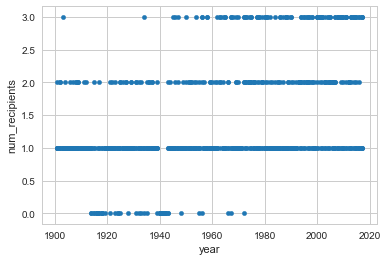

In [89]:
df_awards_past.plot.scatter(x='year', y='num_recipients')

It's hard to see a trend when there are multiple observations per year (**why?**).

Let's try looking at *mean* num recipients by year.

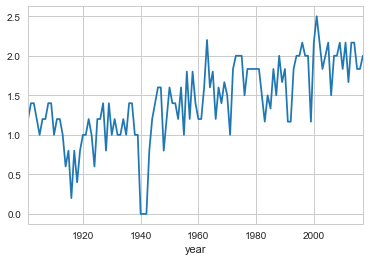

In [90]:
df_awards_past.groupby('year').num_recipients.mean().plot.line()

A complete answer to our question would involve fitting regression models, breaking down by kind of award, etc... here's a quick preview.

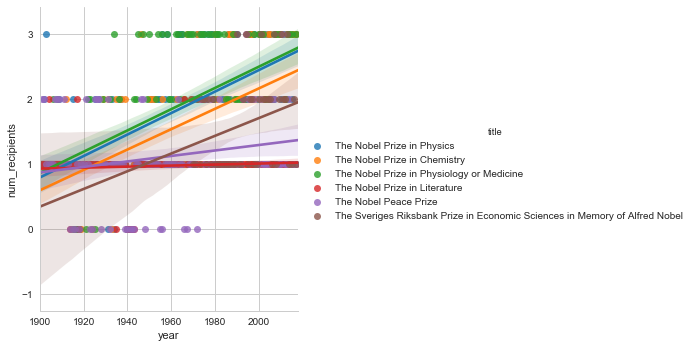

In [91]:
sns.lmplot(x='year', y='num_recipients', hue='title', data=df_awards_past)#, scatter_kws=dict(alpha=.1))
plt.xlim(1900, 2018);

## Did anyone recive the Nobel Prize more than once?

Here's where it bites us that our original DataFrame isn't "tidy". Let's make a tidy one.

In [92]:
tidy_awards = []
for idx, row in df_awards_past.iterrows():
    for recipient in row['recipients']:
        tidy_awards.append(dict(
            recipient=recipient,
            year=row['year']))
tidy_awards_df = pd.DataFrame(tidy_awards)
tidy_awards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 2 columns):
recipient    923 non-null object
year         923 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.5+ KB


Now we can look at each recipient individually.

In [93]:
tidy_awards_df.recipient.value_counts()

Comité international de la Croix Rouge (International Committee of the Red Cross)     3
Marie Curie, née Sklodowska                                                           2
Linus Carl Pauling                                                                    2
Office of the United Nations High Commissioner for Refugees (UNHCR)                   2
Frederick Sanger                                                                      2
John Bardeen                                                                          2
Erik Axel Karlfeldt                                                                   1
Lech Walesa                                                                           1
Luis F. Leloir                                                                        1
Franco Modigliani                                                                     1
Georg Wittig                                                                          1
Nicolaas Bloembergen            

## Other structured data formats: JSON and CSV

### CSV
CSV is a lowest-common-denominator format for tabular data.

In [94]:
df_awards_past.to_csv('awards.csv', index=False)
with open('awards.csv', 'r') as f:
    print(f.read()[:1000])

motivation,num_recipients,recipients,title,year
“for decisive contributions to the LIGO detector and the observation of gravitational waves”,3,"['Rainer Weiss', 'Barry C. Barish', 'Kip S. Thorne']",The Nobel Prize in Physics,2017
“for developing cryo-electron microscopy for the high-resolution structure determination of biomolecules in solution”,3,"['Jacques Dubochet', 'Joachim Frank', 'Richard Henderson']",The Nobel Prize in Chemistry,2017
“for their discoveries of molecular mechanisms controlling the circadian rhythm”,3,"['Jeffrey C. Hall', 'Michael Rosbash', 'Michael W. Young']",The Nobel Prize in Physiology or Medicine,2017
"“who, in novels of great emotional force, has uncovered the abyss beneath our illusory sense of connection with the world”",1,['Kazuo Ishiguro'],The Nobel Prize in Literature,2017
“for its work to draw attention to the catastrophic humanitarian consequences of any use of nuclear weapons and for its ground-breaking efforts to achieve a treaty-based prohibition o

It loses some info, though: the recipients list became a plain string, and the reader needs to guess whether each column is numeric or not.

In [95]:
pd.read_csv('awards.csv').recipients.iloc[20]

"['John O’Keefe', 'May-Britt Moser', 'Edvard I. Moser']"

### JSON

JSON preserves structured data, but fewer data-science tools speak it.

In [96]:
df_awards_past.to_json('awards.json', orient='records')

with open('awards.json', 'r') as f:
    print(f.read()[:1000])

[{"motivation":"\u201cfor decisive contributions to the LIGO detector and the observation of gravitational waves\u201d","num_recipients":3,"recipients":["Rainer Weiss","Barry C. Barish","Kip S. Thorne"],"title":"The Nobel Prize in Physics","year":2017},{"motivation":"\u201cfor developing cryo-electron microscopy for the high-resolution structure determination of biomolecules in solution\u201d","num_recipients":3,"recipients":["Jacques Dubochet","Joachim Frank","Richard Henderson"],"title":"The Nobel Prize in Chemistry","year":2017},{"motivation":"\u201cfor their discoveries of molecular mechanisms controlling the circadian rhythm\u201d","num_recipients":3,"recipients":["Jeffrey C. Hall","Michael Rosbash","Michael W. Young"],"title":"The Nobel Prize in Physiology or Medicine","year":2017},{"motivation":"\u201cwho, in novels of great emotional force, has uncovered the abyss beneath our illusory sense of connection with the world\u201d","num_recipients":1,"recipients":["Kazuo Ishiguro"],"

Lists and other basic data types are preserved. (Custom data types aren't preserved, but you'll get an error when saving.)

In [97]:
pd.read_json('awards.json').recipients.iloc[20]

['John O’Keefe', 'May-Britt Moser', 'Edvard I. Moser']

### (Bonus: Pickle)
For temporary data storage in a single version of Python, `pickle`s will preserve your data even more faithfully, even many custom data types. But don't count on it for exchanging data or long-term storage. (In fact, don't try to load untrusted `pickle`s -- they can run arbitrary code!)

In [98]:
df_awards_past.to_pickle('awards.pkl', protocol=0)
with open('awards.pkl', 'r', encoding='latin1') as f:
    print(f.read()[:200])

TypeError: to_pickle() got an unexpected keyword argument 'protocol'

Yup, lots of internal Python and Pandas stuff...

In [ ]:
pd.read_pickle('awards.pkl').recipients.iloc[20]

## Formatted data output

Let's make a textual table of Physics laureates by year, earliest first:

In [ ]:
for idx, row in df_awards_past.sort_values('year').iterrows():
    if 'Physics' in row['title']:
        print('{}: {}'.format(
            row['year'],
            ', '.join(row['recipients'])))


## Parsing JSON to get the Wayback Machine URL

We could go to http://archive.org, search for our URL, and get the URL for the archived version there. But since you'll often need to talk with APIs, let's take this opportunity to use the Wayback Machine's [API](https://archive.org/help/wayback_api.php). This will also give us a chance to practice working with JSON.

In [ ]:
url = "https://www.nobelprize.org/prizes/lists/all-nobel-prizes/"
# All 3 of these do the same thing. The third is my (KCA's) favorite new feature of Python 3.6.
wayback_query_url = 'http://archive.org/wayback/available?url={}'.format(url)
wayback_query_url = 'http://archive.org/wayback/available?url={url}'.format(url=url)
wayback_query_url = f'http://archive.org/wayback/available?url={url}'
r = requests.get(wayback_query_url)

We got some kind of response... what is it?

In [ ]:
r.text

Yay, [JSON](https://en.wikipedia.org/wiki/JSON)! It's usually pretty easy to work with JSON, once we parse it.

In [ ]:
json.loads(r.text)

Loading responses as JSON is so common that `requests` has a convenience method for it:

In [ ]:
response_json = r.json()
response_json

**What kind of object is this?**

A little Python syntax review: **How can we get the snapshot URL?**

In [ ]:
snapshot_url = response_json['archived_snapshots']['closest']['url']
snapshot_url

---